In [1]:
from data.get_data import *
from metrics import *
from technical_feature_helpers import *
import matplotlib.pyplot as plt


# Load the Data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Downloaded 4695 intra-day intervals
Period: 2007-01-03 00:00:00 to 2025-08-29 00:00:00
Trading days: 4695

Data saved to TLT_2007-01-01_to_2025-08-30.csv


,Price,High,Low,Realized_Vol
Date,,,,
2007-01-03,50.249763,50.475454,50.024077,NaN
2007-01-04,50.554432,50.582645,50.340029,NaN
2007-01-05,50.334381,50.441585,50.074839,NaN
2007-01-08,50.424675,50.424675,50.244124,NaN
2007-01-09,50.424675,50.486740,50.340041,NaN
...,...,...,...,...
2025-08-25,86.471245,86.720298,86.321811,0.091748
2025-08-26,86.421432,86.461282,85.893441,0.088227
2025-08-27,86.321815,86.331780,85.674276,0.078127


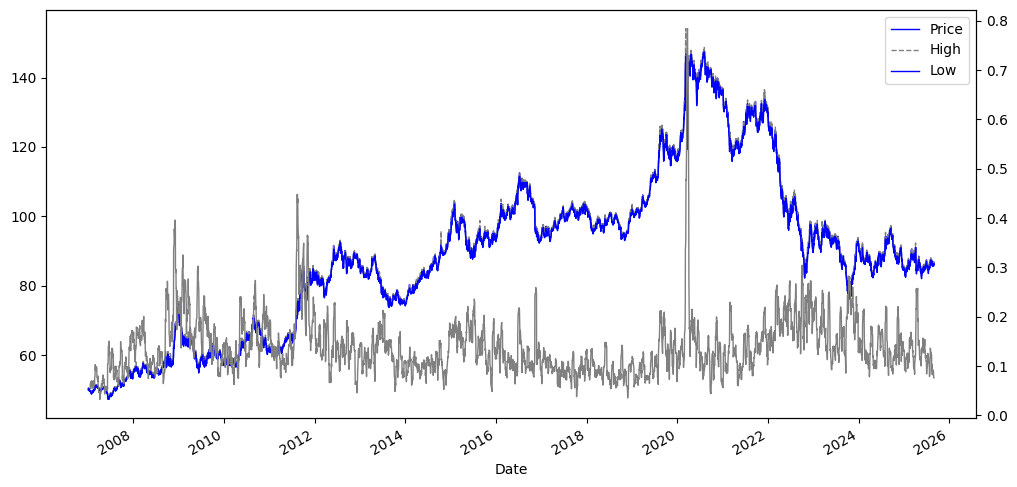

In [ ]:
price_vol_df = get_data(
    ticker = 'TLT',
    start_date=DATA_START_DATE, 
    end_date=DATA_END_DATE, 
    vol_window_days=VOL_WINDOW_DAYS,
    save_csv=False, 
    plot_data=PLOT_DATA
    )

price_vol_df


# Get Features

In [9]:
price_vol_df['lagged_vol'] = price_vol_df['Realized_Vol']
price_vol_df['rsi'] = calculate_rsi_talib(price_vol_df['Price'], period= 10)
price_vol_df['macd'] = calculate_macd_talib(price_vol_df['Price'], fast=5, slow=15)
price_vol_df = calculate_bull_bear_power(price_vol_df.copy(), period = 5)

# Lag target variable
price_vol_df['Realized_Vol'] = price_vol_df['Realized_Vol'].shift(-1)

# Difference
price_vol_diff = price_vol_df.copy()\
    .diff()\
        .dropna()

price_vol_diff = price_vol_diff.drop(columns=['Price', 'High', 'Low'])
price_vol_diff

,Realized_Vol,lagged_vol,rsi,macd,EMA,Bull_Power,Bear_Power
Date,,,,,,,
2007-02-06,0.000088,0.006812,9.077741,0.097070,0.128250,0.081351,-0.128263
2007-02-07,0.000687,0.000088,4.116488,0.088993,0.134599,0.029697,0.250635
2007-02-08,0.003802,0.000687,1.087735,0.058152,0.102958,0.004698,-0.063277
2007-02-09,0.001354,0.003802,-10.713977,-0.029541,-0.025782,-0.195164,-0.178169
2007-02-12,0.001951,0.001354,-3.636907,-0.044053,-0.054953,-0.097996,-0.069673
...,...,...,...,...,...,...,...
2025-08-19,0.000961,0.005081,6.207752,0.010415,-0.021413,0.230619,0.479672
2025-08-20,-0.003521,0.000961,2.241028,0.053005,0.048814,0.170348,0.060764
2025-08-21,-0.010100,-0.003521,-4.897095,-0.053032,-0.110244,-0.178655,-0.338045


# Simple linear regression

<Axes: xlabel='Date'>

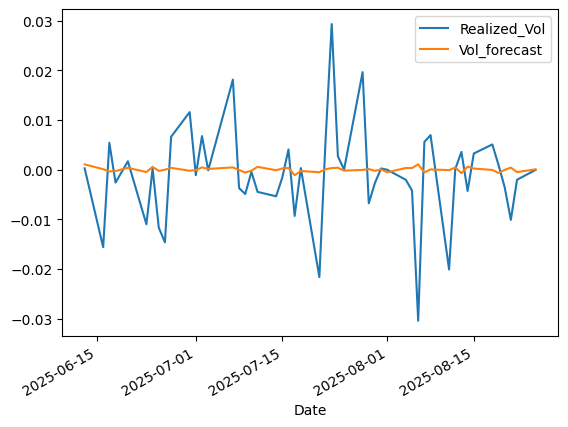

In [37]:
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

cols = ['Realized_Vol', 'lagged_vol', 'rsi', 'macd', 'Bull_Power', 'Bear_Power']
test_size = 50
test = price_vol_diff[-test_size:]
y_pred = []

pipeline = Pipeline([
        ('pca', PCA(n_components=3)),  # Dimensionality reduction
        ('lasso', Ridge(random_state=2025))  # Lasso regression
    ])

for i in range(test_size):
    train = price_vol_diff[:-(test_size-i)]
    # Build and train the pipeline
    pipeline.fit(train.drop(columns=['Realized_Vol']), train['Realized_Vol'])

    # Make predictions
    y_pred += [pipeline.predict(test.iloc[i:i+1].drop(columns=['Realized_Vol']))[0]]

eval_df = test[['Realized_Vol']].copy()
eval_df['Vol_forecast'] = y_pred

eval_df.plot()

In [38]:
comprehensive_evaluation(eval_df['Realized_Vol'], eval_df['Vol_forecast'], benchmark_pred=eval_df['Vol_forecast'], returns=None, volatility_forecast=None, alpha=0.05)

=== STATISTICAL METRICS ===
MSPE: 36.865873
QLIKE: -4.249836

=== COMPARATIVE TESTS ===
Diebold-Mariano Test (QLIKE):
  Statistic: nan, p-value: nan
Model Confidence Set:
  Model: IN (p-value: 1.0000)
  Benchmark: OUT (p-value: nan)


{'MSPE': 36.86587282001344,
 'QLIKE': -4.2498364777089765,
 'DM_statistic': nan,
 'DM_pvalue': nan,
 'MCS': {'Model': {'in_mcs': True, 'p_value': 1.0},
  'Benchmark': {'in_mcs': False, 'p_value': nan}},
 'Best_Model': 'Model'}